In [1]:
!pip install xgboost
!pip install sklearn
!pip install Keras
!pip install tensorflow

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import precision_score, make_scorer, log_loss, accuracy_score, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

%reload_ext autoreload
%autoreload 1
%aimport utils

og_data = pd.read_csv('data.csv', parse_dates=['game_date'])
utils.engineer_features_and_write_file(og_data)
og_data = pd.read_csv('data_engineered.csv', parse_dates=['game_date'])
og_data = og_data.sort_values(by="game_event_id")

In [3]:
#feature engineering
#data parsing
og_data.seconds_remaining = pd.to_timedelta(og_data.seconds_remaining, unit='s')
og_data.minutes_remaining = pd.to_timedelta(og_data.minutes_remaining, unit='m')
og_data['time_remaining'] = og_data.minutes_remaining+og_data.seconds_remaining

#binning of time_remaining
time_remaining_bins_labels = [[
    pd.Timedelta(minutes = 0),
    pd.Timedelta(minutes = 5),
    pd.Timedelta(minutes = 10),
    pd.Timedelta(minutes = 20)
], ['0-5min', '5-10min', '10-20min']]

og_data['time_remaining_label'] = pd.cut(og_data['time_remaining'], time_remaining_bins_labels[0], labels = time_remaining_bins_labels[1])
og_data['time_remaining_label2']=og_data['time_remaining_label'].astype('category').cat.codes

# Handle dates
og_data["game_year"] = og_data["game_date"].dt.year
og_data["game_month"] = og_data["game_date"].dt.month
og_data["game_day"] = og_data["game_date"].dt.day

# Calculate shot efficiency per month
efficiency_by_month = (og_data.groupby(['game_year', 'game_month'], dropna=True)["shot_made_flag"].sum() 
                       / og_data.groupby(['game_year', 'game_month'], dropna=True)["shot_made_flag"].count()
                      ).shift(1, fill_value=0.4400971254369479)

og_data = og_data.join(efficiency_by_month, on=['game_year', 'game_month'], how='left', lsuffix='', rsuffix='_pct')

#use only if data needs to be regenerated
utils.engineer_features_and_write_file(og_data)

#there are 5000 shot_made_flag null values, that's our test data, the rest is training data
test = og_data.loc[og_data['shot_made_flag'].isnull()]
data = og_data.loc[og_data['shot_made_flag'].notnull()]

feature_switch = {
    'distance_traveled': 1,
    'two_pt_attempted' : 1,
    'three_pt_attempted': 1,
    'pts_attempted': 0,
    'right_of_net': 0,
    'shot_distance': 1,
    'period': 1,
    'home_game': 1,
    'shot_zone_area2': 0,
    'playoffs': 0,
    'time_remaining_label2': 1,
    'action_type2': 1,
    'combined_shot_type2': 1,
    'opponent2': 1,
    'game_year': 1,
    'game_month': 0,
    'game_day': 0,
    'angle': 1,
    'shot_made_flag_pct': 1,
}

chosen_features = [key for key, value in feature_switch.items() if value == 1]

data.columns


Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id',
       'two_pt_attempted', 'three_pt_attempted', 'pts_attempted',
       'action_type2', 'combined_shot_type2', 'opponent2', 'home_game',
       'shot_zone_area2', 'angle', 'distance', 'distance_traveled',
       'right_of_net', 'time_remaining', 'time_remaining_label',
       'time_remaining_label2', 'game_year', 'game_month', 'game_day',
       'shot_made_flag_pct'],
      dtype='object')

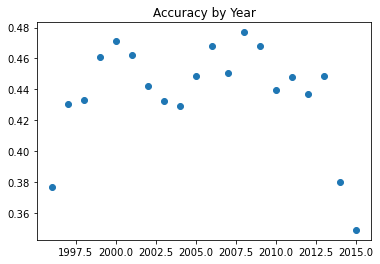

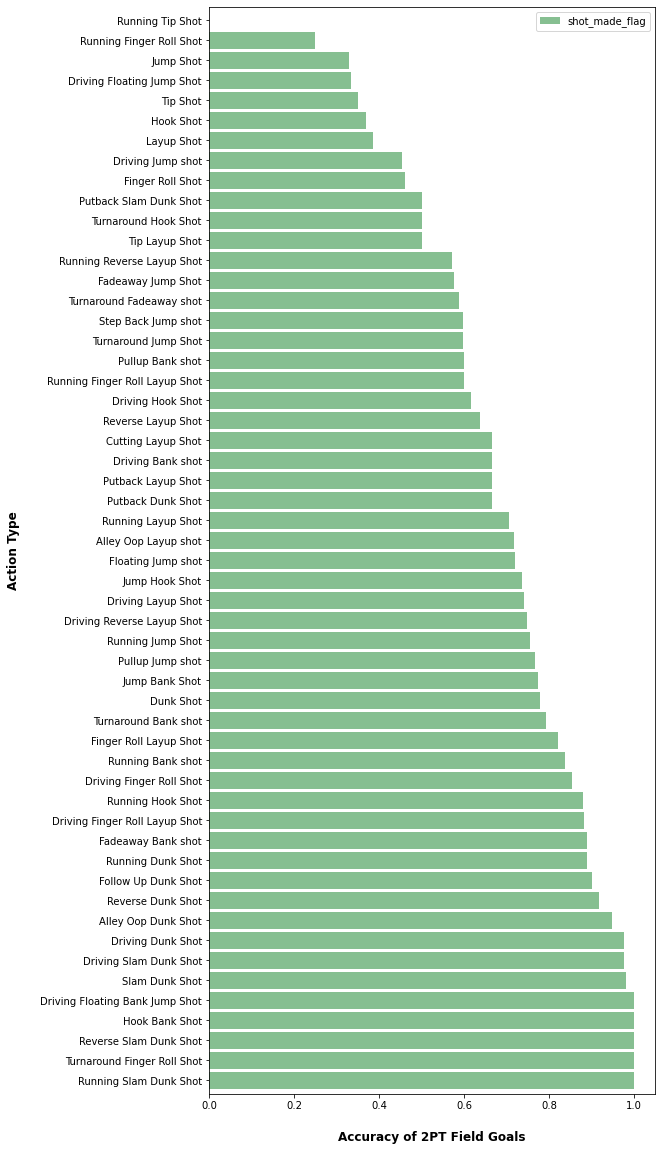

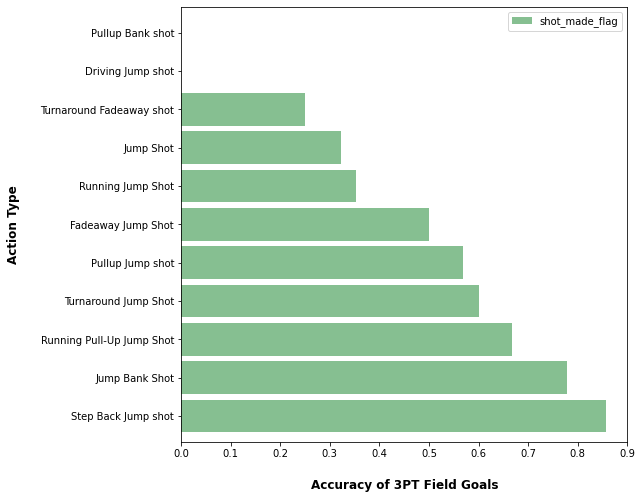

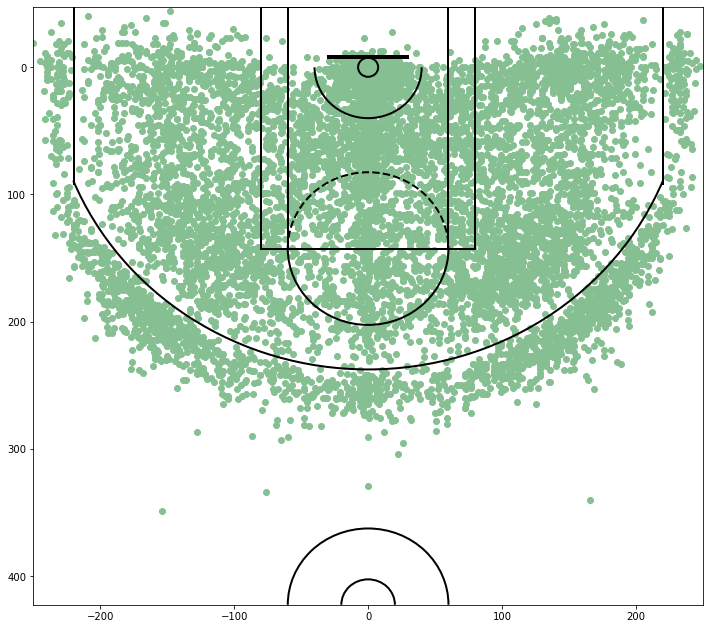

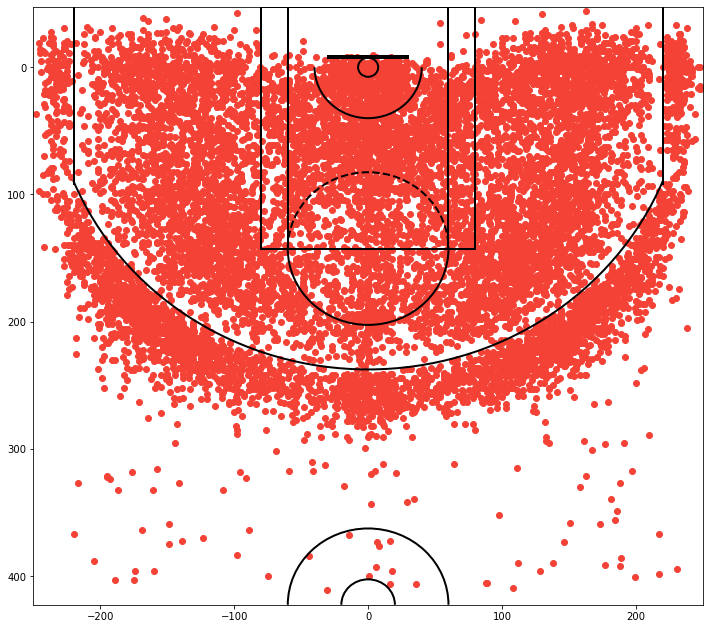

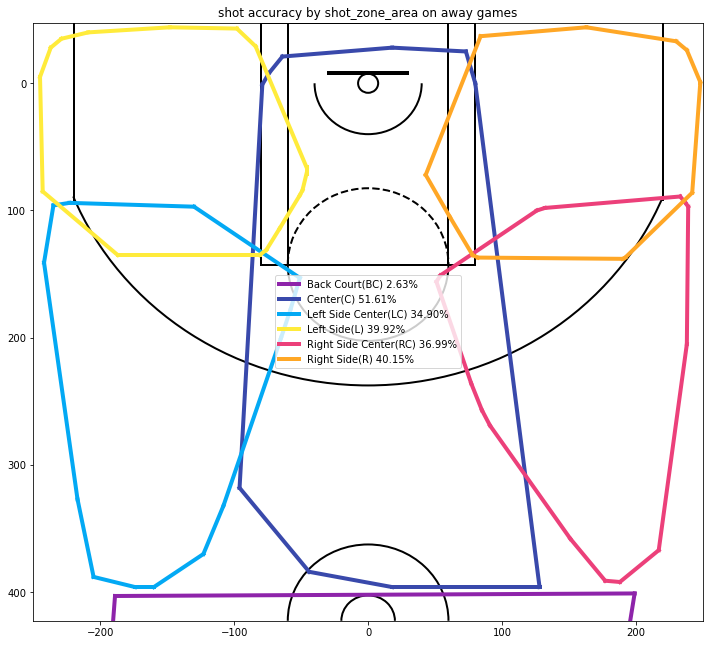

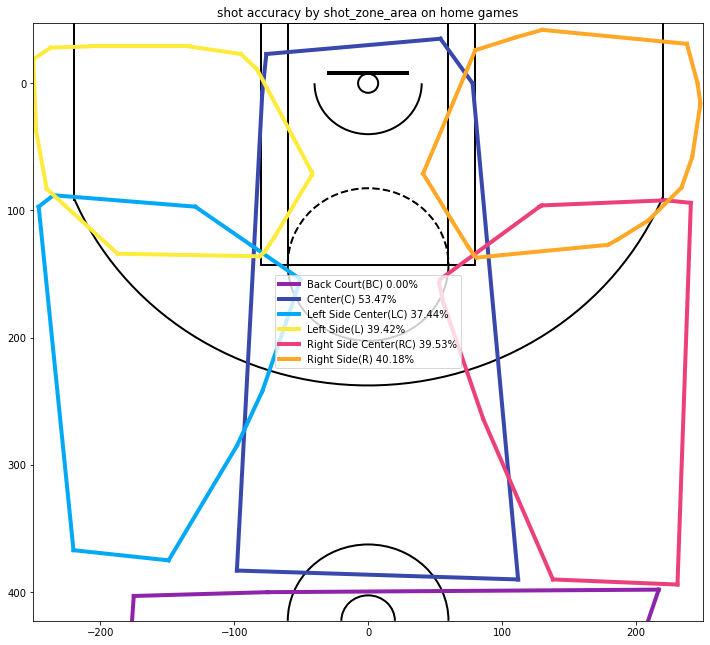

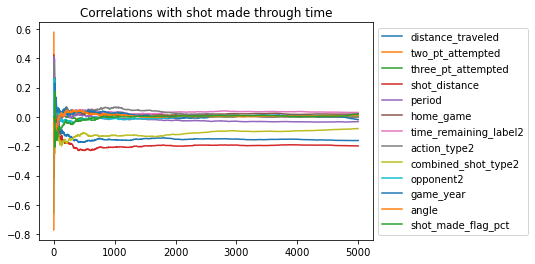

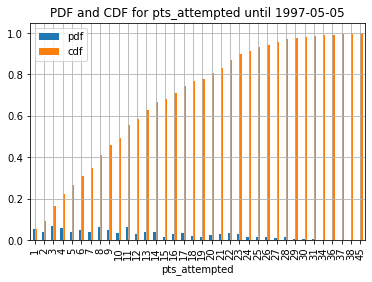

In [4]:
utils.draw_exploratory_data_charts(data, test, chosen_features)

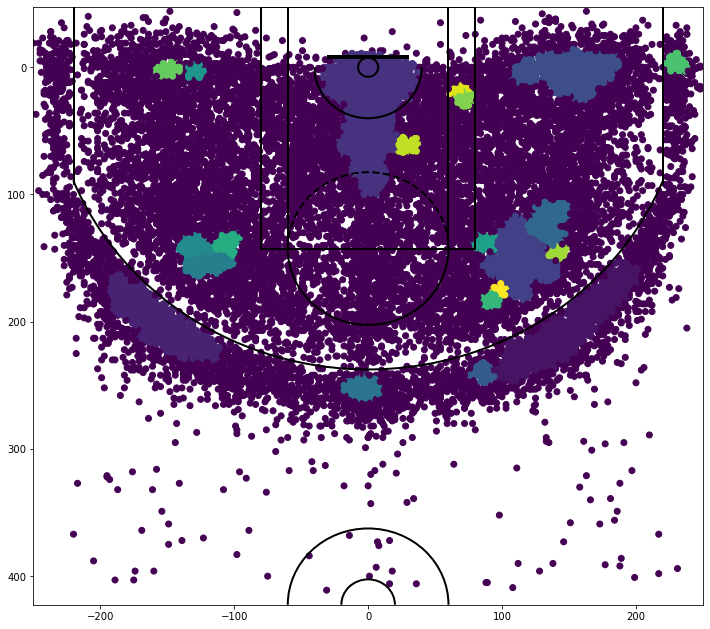

In [5]:
utils.db_scan(data)

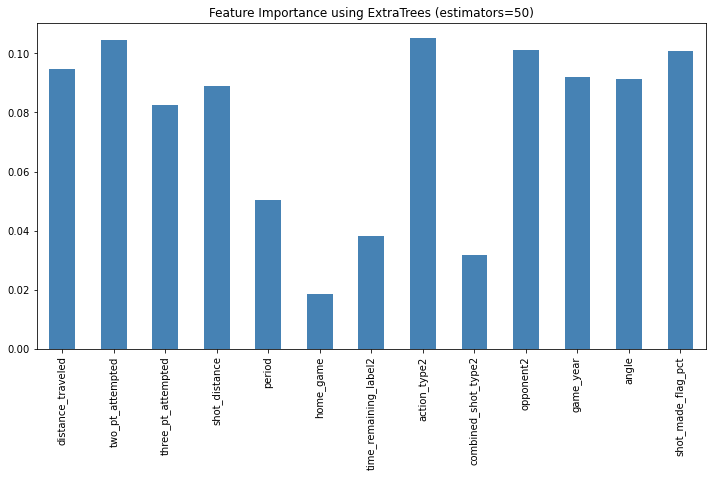

In [6]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
# print(X_new.shape)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using ExtraTrees (estimators=50)');

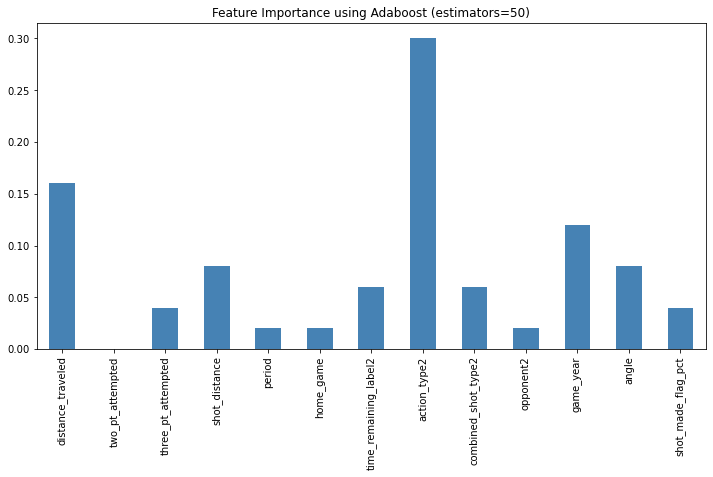

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = AdaBoostClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
# print(X_new.shape)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using Adaboost (estimators=50)');

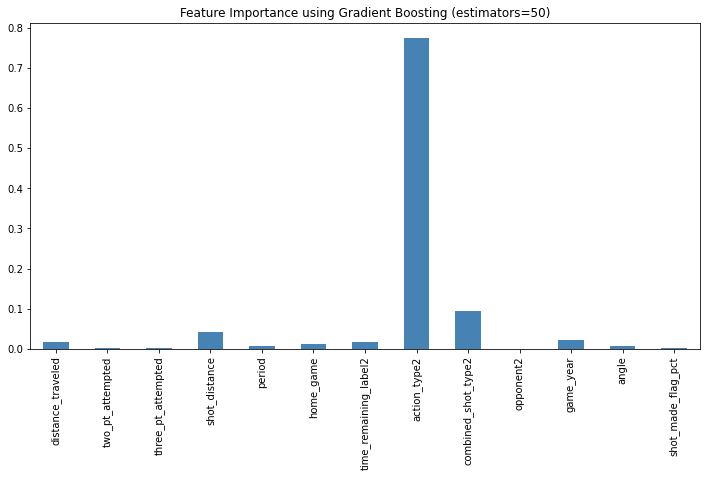

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = GradientBoostingClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using Gradient Boosting (estimators=50)');

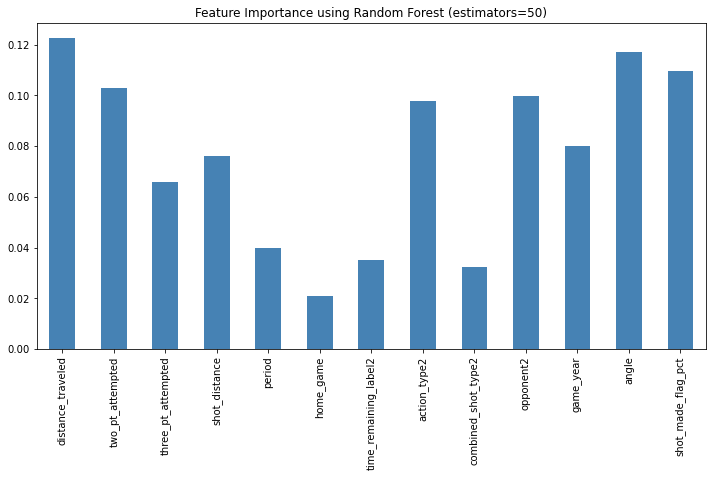

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

y = data['shot_made_flag']
X = data[chosen_features]

# print(X.shape)

clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

pd.Series(clf.feature_importances_, index=chosen_features).plot.bar(color='steelblue', figsize=(12, 6), title='Feature Importance using Random Forest (estimators=50)');

In [10]:
X = data[chosen_features]
y = data['shot_made_flag']
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

print("Five-fold cross validation on Gradient Boosting: ")
gradient = GradientBoostingClassifier(n_estimators=100, max_depth=4)

score = cross_val_score(gradient, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on Gradient Boosting: 
0.6662263775220088


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

print("Five-fold cross validation on Random Forest: ")

rf = RandomForestClassifier(n_estimators=200, max_depth=8)

score = cross_val_score(rf, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on Random Forest: 
0.678756620426842


In [13]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

print("Five-fold cross validation on AdaBoost: ")
adaBoost = AdaBoostClassifier(n_estimators=100, random_state=0)

score = cross_val_score(adaBoost, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on AdaBoost: 
0.6666549761002118


In [14]:
# tscv = TimeSeriesSplit()
# params = {
#     "loss":["deviance"],
#     "learning_rate":[0.01, 0.025, 0.05, 0.075, 0.1, 0.2],
#     "n_estimators":[10, 50, 100, 200, 300, 400, 500, 600],
#     "subsample":[0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
#     "criterion":['friedman_mse', 'mae'],
#     "max_depth":[3, 4, 5, 8],
#     "max_features":["sqrt", "log2"],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12)
# }
# clf = GridSearchCV(GradientBoostingClassifier(), params, cv=tscv)
# clf.fit(X, y)
# print(clf.score(X, y))
# print(clf.best_params_)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
print("Five-fold cross validation on XGBoost: ")

clf = xgb.XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.04, max_depth= 4, min_child_weight= 10, n_estimators= 1000, objective= 'binary:logistic', seed= 1000, subsample= 0.8)
score = cross_val_score(clf, X, y, cv=5)
print(sum(score) / len(score))

Five-fold cross validation on XGBoost: 
0.6424115276253991


In [16]:
print("Five-fold Time Series Split on XGBoost: ")
clfxgb = xgb.XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='binary:hinge')
score = cross_val_score(clf, X, y, cv=TimeSeriesSplit())
print(sum(score) / len(score))

Five-fold Time Series Split on XGBoost: 
0.6702475478748248


In [20]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

n_splits = 5

parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.04], 
              'max_depth': [4],
              'min_child_weight': [12],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], 
              'seed': [1000]}

clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy')
clf.fit(X, y)
print(cross_val_score(clf, X, y, scoring='accuracy', cv=TimeSeriesSplit(n_splits=n_splits)))

print(clf.best_params_)

[0.63194769 0.67048108 0.66791219 0.68239141 0.69827184]
{'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 4, 'min_child_weight': 12, 'n_estimators': 1000, 'objective': 'binary:logistic', 'seed': 1000, 'subsample': 0.8}


In [21]:
print(clf.score(X, y))

0.7086430322605751


In [22]:
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# parameters = {'objective':['binary:logistic'],
#               'learning_rate': [0.04, 0.05, 0.06, 0.07], 
#               'max_depth': [4, 5, 6, 7],
#               'min_child_weight': [11, 10, 9, 12],
#               'subsample': [0.8],
#               'colsample_bytree': [0.7],
#               'n_estimators': [1000], 
#               'seed': [1000]}

# clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=TimeSeriesSplit())
# clf.fit(X, y)
# print(cross_val_score(clf, X, y, scoring='accuracy', cv=TimeSeriesSplit(n_splits=n_splits)))
# print(clf.best_params_)

[0.63171415 0.67024755 0.66043905 0.68262494 0.69850537]
{'colsample_bytree': 0.7, 'learning_rate': 0.04, 'max_depth': 4, 'min_child_weight': 10, 'n_estimators': 1000, 'objective': 'binary:logistic', 'seed': 1000, 'subsample': 0.8}


In [41]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(criterion='entropy',
                              n_estimators=300, random_state=1, max_depth=8)
clf3 = GaussianNB()
clf4 = AdaBoostClassifier(base_estimator = clf1)
clf5 = AdaBoostClassifier(base_estimator = RandomForestClassifier(criterion='entropy', n_estimators=2, random_state=1))
clf6 = AdaBoostClassifier(base_estimator = clf3)
clf7 = AdaBoostClassifier(n_estimators=100, random_state=0)
clf8 = ExtraTreesClassifier(n_estimators=50)
clf9 = GradientBoostingClassifier(n_estimators=400, max_depth=4)
clf10 = xgb.XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.04, max_depth= 4, min_child_weight= 10, n_estimators= 1000, objective= 'binary:logistic', seed= 1000, subsample= 0.8)
eclf = VotingClassifier(
estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3), ('lrada', clf4), ('rfada', clf5), ('gnada', clf6), ('ada', clf7), ('extra', clf8), ('gradient', clf9), ('xgb', clf10)],
voting='hard')

seclf = StackingClassifier(estimators=[('rf', clf2), ('ada', clf7), ('gradient', clf9)], final_estimator=RandomForestClassifier(criterion='entropy', n_estimators=2, random_state=1))

final_scores = {'scores': [], 'labels': []}
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, clf10, eclf, seclf], ['Logistic Regression', 'Random Forest', 'Naïve Bayes', 'Logistic Regression (Ada)', 'Random Forest (Ada)', 'Naïve bayes (Ada)', 'Adaboost', 'ExtraTrees','Gradient Boosting', 'XGB Classifier', 'Ensemble', "Stacking Classifier"]):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=TimeSeriesSplit(n_splits=n_splits))
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    final_scores['scores'].append(scores)
    final_scores['labels'].append(label)

Accuracy: 0.60 (+/- 0.01) [Logistic Regression]
Accuracy: 0.69 (+/- 0.01) [Random Forest]
Accuracy: 0.64 (+/- 0.01) [Naïve Bayes]
Accuracy: 0.59 (+/- 0.01) [Logistic Regression (Ada)]
Accuracy: 0.59 (+/- 0.01) [Random Forest (Ada)]
Accuracy: 0.43 (+/- 0.07) [Naïve bayes (Ada)]
Accuracy: 0.68 (+/- 0.02) [Adaboost]
Accuracy: 0.65 (+/- 0.01) [ExtraTrees]
Accuracy: 0.66 (+/- 0.02) [Gradient Boosting]
Accuracy: 0.67 (+/- 0.02) [XGB Classifier]
Accuracy: 0.68 (+/- 0.01) [Ensemble]
Accuracy: 0.61 (+/- 0.02) [Stacking Classifier]


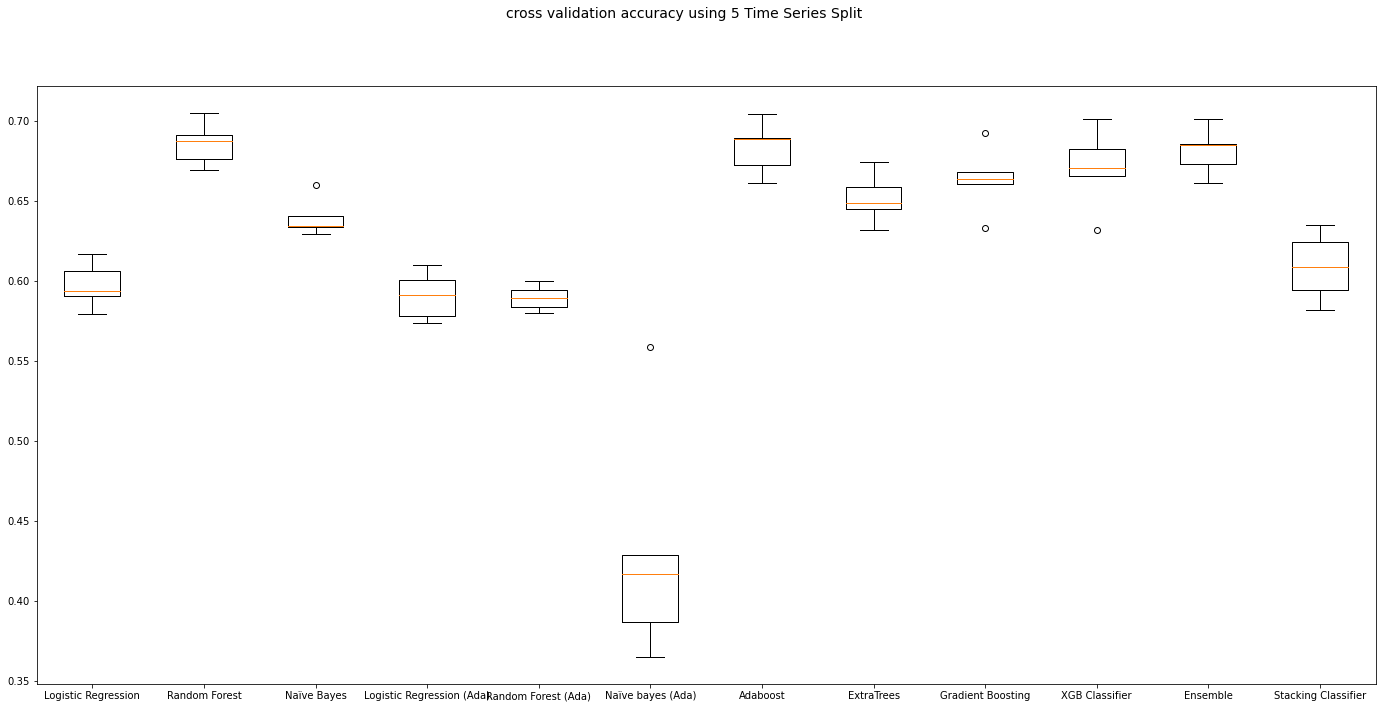

In [51]:
fig = plt.figure(figsize=(24, 11))
fig.suptitle('cross validation accuracy using ' + str(n_splits) + ' Time Series Split', fontsize=14)
ax = fig.add_subplot(111)
plt.boxplot(final_scores['scores'])
ax.set_xticklabels(final_scores['labels'])
plt.show()

In [62]:
n_features = X.shape[1]
X = data[chosen_features]
def create_dense_nn():
    model = Sequential()
    model.add(Dense(n_features, input_dim=n_features))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'logloss'])
    return model

In [63]:
from statistics import mean
model = KerasClassifier(build_fn=create_dense_nn, epochs=100, batch_size=10, verbose=2)
results = cross_validate(model, X, y, cv=TimeSeriesSplit(), scoring=['neg_log_loss', 'accuracy'])
print(mean(results))

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100


TypeError: can't convert type 'str' to numerator/denominator

In [64]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [65]:
Xtest = test[chosen_features]
scaler = StandardScaler().fit(Xtest)
Xtest = scaler.transform(Xtest)
clf10.fit(X, y)
prediction = clf10.predict_proba(Xtest)

In [66]:
ans = []
for p in prediction:
    ans.append(p[1])
predictions = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
predictions.sort_values(by='shot_id', inplace=True)
predictions.to_csv("../pred_xgb.csv", index=False)

In [67]:
predictions

shot_id  shot_made_flag
0            1        0.928781
7            8        0.931610
16          17        0.871880
19          20        0.920047
32          33        0.930582
...        ...             ...
30668    30669        0.925887
30680    30681        0.582474
30682    30683        0.915967
30686    30687        0.921233
30693    30694        0.789264

[5000 rows x 2 columns]

In [68]:
Xtest = test[chosen_features]
scaler = StandardScaler().fit(Xtest)
Xtest = scaler.transform(Xtest)
clf2.fit(X, y)
prediction = clf2.predict_proba(Xtest)

In [69]:
ans = []
for p in prediction:
    ans.append(p[1])
predictions = pd.DataFrame.from_dict({"shot_id": test.shot_id, "shot_made_flag":ans})
predictions.sort_values(by='shot_id', inplace=True)
predictions.to_csv("../pred_rf.csv", index=False)